## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


## Task 2 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

In [ ]:
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg = vgg.features

In [ ]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Freeze the feature extractor layer

In [ ]:
for param in vgg.parameters():
  param.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
vgg = vgg.to(device)

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from PIL import Image
from pathlib import Path
from torchvision import transforms 

In [ ]:
def tfm_img(imgpath, max_size=500):
  img = Image.open(imgpath).convert('RGB')
   
  if max(img.size) > max_size:
    size = max_size
  else:
    size = max(img.size)
  
  tfms = transforms.Compose([
                             transforms.Resize(size),
                             transforms.ToTensor(), # (0,1)
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet stats
  ])

  img = tfms(img).unsqueeze(0)
  return img

In [ ]:
img_path = Path('/content/Project-NST/content10.jpg')
sty_path = Path('/content/Project-NST/style10.jpg')
img = tfm_img(img_path)
sty = tfm_img(sty_path)

In [ ]:
img.max(), img.min(), img.std(), img.mean(), sty.max(), sty.min(), sty.std(), sty.mean()

(tensor(2.6400),
 tensor(-2.1179),
 tensor(1.2572),
 tensor(0.8222),
 tensor(2.2489),
 tensor(-2.1179),
 tensor(1.3220),
 tensor(-0.3794))

In [ ]:
img.shape, sty.shape

(torch.Size([1, 3, 487, 487]), torch.Size([1, 3, 500, 765]))

In [ ]:
img = img.to(device)
sty = sty.to(device)

## Task 4 : Deprocess image

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def undo_tfm_img(img: torch.Tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  img = img.clone().detach().cpu().squeeze()
  img = img.permute(1,2,0).numpy()
  img = img * np.array(std) + np.array(mean)
  return img.clip(0,1)

In [ ]:
img_d = undo_tfm_img(img)

In [ ]:
img_d.shape

(487, 487, 3)

In [ ]:
img_d.max(), img_d.min()

(1.0, 0.0)

In [ ]:
sty_d = undo_tfm_img(sty)

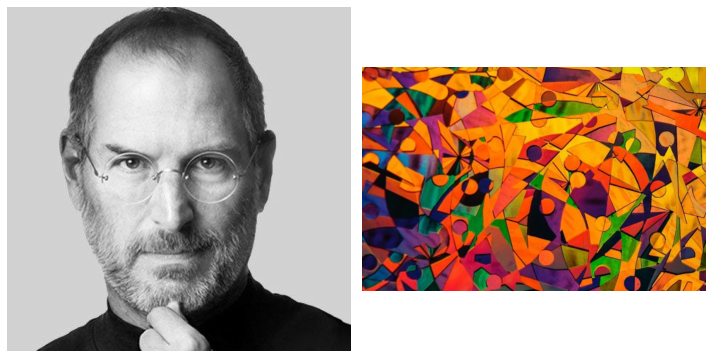

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img_d)
ax[0].axis('off')
ax[1].imshow(sty_d)
ax[1].axis('off')
fig.tight_layout()

## Task 5 : Get content,style features and create gram matrix

In [ ]:
"""
for name, mod in vgg.named_modules():
  print(name, mod)
"""

'\nfor name, mod in vgg.named_modules():\n  print(name, mod)\n'

In [ ]:
list(vgg.named_modules())[1]

('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [ ]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace=Tru

In [ ]:
def get_features(img, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2', # content feature
      '28': 'conv5_1',
  }
  x = img.clone()
  device = x.device
  features = {}
  model_layers = model._modules.items() # returns ordered dict
  for name, module in model_layers:
    x = module.to(device)(x)  # apply each layer 
    if name in layers: # if in 0, 5, ..
      features[layers[name]] = x
  return features

In [ ]:
sty.shape, img.shape

(torch.Size([1, 3, 500, 765]), torch.Size([1, 3, 487, 487]))

In [ ]:
img_feats = get_features(img, vgg)
sty_feats = get_features(sty, vgg)

In [ ]:
img_feats.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [ ]:
sty_feats.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

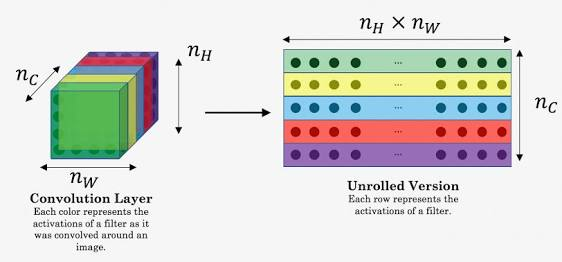

In [ ]:
img.size()

torch.Size([1, 3, 487, 487])

In [ ]:
def unroll(img:torch.Tensor):
  """
  cannot handle batches
  """
  b, c, h, w = img.shape
  return img.reshape(c, h*w)

In [ ]:
unroll(img).shape

torch.Size([3, 237169])

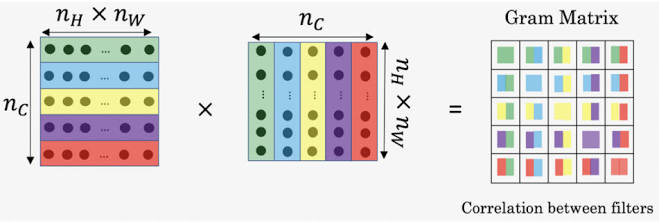

In [ ]:
unroll(img).T.shape

torch.Size([237169, 3])

In [ ]:
def calc_gram_matrix(img:torch.Tensor):
  img_ur = unroll(img)
  gram_matrix = torch.mm(img_ur, img_ur.T)
  return gram_matrix

In [ ]:
img_grams = {l: calc_gram_matrix(img_feats[l]) for l in img_feats} 

In [ ]:
img_grams['conv1_1'].shape

torch.Size([64, 64])

In [ ]:
style_grams = {l: calc_gram_matrix(sty_feats[l]) for l in sty_feats} 

In [ ]:
style_grams['conv1_1'].shape

torch.Size([64, 64])

## Task 6 : Creating Style and Content loss function

Content loss between target and content 4_2 only!

In [ ]:
def content_loss(target_42, content_42):
  loss = torch.mean((target_42 - content_42)**2)
  return loss

Weights are there for each conv layer outs of style. do not use conv_4_2

In [ ]:
style_weights = {
      'conv1_1': 1.0,
      'conv2_1': 0.75,
      'conv3_1': 0.2,
      'conv4_1': 0.2,
      'conv5_1': 0.2,
  }

In [ ]:
def style_loss(style_weights, target_feats, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_feats[layer]
    b, c, h, w = target_f.shape  # shape of each conv outs
    target = calc_gram_matrix(target_f)
    style = style_grams[layer]
    layer_loss = style_weights[layer] * torch.mean((target-style)**2)
    loss += layer_loss/(c*h*w)
  return loss


Initialize target image. can do random noise or content image

In [ ]:
img.shape

torch.Size([1, 3, 487, 487])

In [ ]:
target = torch.rand_like(img, requires_grad=True) # on device cuda

In [ ]:
undo_tfm_img(target).shape

(487, 487, 3)

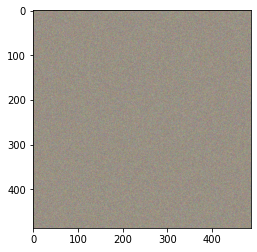

In [ ]:
ax = plt.imshow(undo_tfm_img(target))

In [ ]:
target_feats = get_features(target, vgg)

In [ ]:
c_loss = content_loss(target_feats['conv4_2'], img_feats['conv4_2'])
c_loss

tensor(3.3691, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
s_loss = style_loss(style_weights, target_feats, style_grams)
s_loss

tensor(3679.3152, device='cuda:0', grad_fn=<AddBackward0>)

## Task 7 : Training loop

In [ ]:
from torch import optim

Here we want to learn the pixel values so pass target as the parameters


In [ ]:
optimizer = optim.Adam([target], lr=1e-3)
alpha = 1.
beta = 1e5
epochs = 3000
show_every = 500

In [ ]:
def total_loss(c_loss, s_loss, alpha=1., beta=1e5):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [ ]:
total_loss(c_loss, s_loss)

tensor(3.6793e+08, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
from tqdm import tqdm

In [ ]:
def train(img_path, sty_path, model, epochs=1, show_every=50):
  results = []
  # load image as tensor
  img = tfm_img(img_path)
  sty = tfm_img(sty_path)
  # get features from model
  img_feats = get_features(img, model)
  sty_feats = get_features(sty, model)
  # get style gram matrix of style features
  style_grams = {l: calc_gram_matrix(sty_feats[l]) for l in sty_feats} 
  # prepare a target image of output shape image
  #target = torch.rand_like(img)
  #target.requires_grad_(True) # on device cuda
  target = img.clone()
  target.requires_grad_(True) 
  optimizer = optim.Adam([target], lr=3e-1)
  progress = tqdm(range(epochs))
  for i in progress:
    target_feats = get_features(target, model)
    c_loss = content_loss(target_feats['conv4_2'], img_feats['conv4_2'])
    s_loss = style_loss(style_weights, target_feats, style_grams)
    loss = total_loss(c_loss, s_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not i%show_every:
      tqdm.write(f' epoch: {i}, loss: {loss.item()}')
      results.append(undo_tfm_img(target.clone())) # so that it can be visualized
  return results

In [ ]:
img_path = Path('/content/pp.jpeg')
sty_path = Path('/content/christmas-happy-new-year-seamless-pattern-with-christmas-sweet-drink-vector-design-template_1015-2264.jpeg')

In [ ]:
results = train(img_path, sty_path, vgg, 300)

  0%|          | 1/300 [00:06<32:32,  6.53s/it]

 epoch: 0, loss: 116785264.0


 17%|█▋        | 51/300 [05:37<27:25,  6.61s/it]

 epoch: 50, loss: 3540796.75


 34%|███▎      | 101/300 [11:01<21:31,  6.49s/it]

 epoch: 100, loss: 1803927.375


 50%|█████     | 151/300 [16:25<16:04,  6.47s/it]

 epoch: 150, loss: 1431849.0


 67%|██████▋   | 201/300 [21:50<10:42,  6.49s/it]

 epoch: 200, loss: 1309754.875


 84%|████████▎ | 251/300 [27:14<05:17,  6.48s/it]

 epoch: 250, loss: 1605990.375


100%|██████████| 300/300 [32:32<00:00,  6.51s/it]


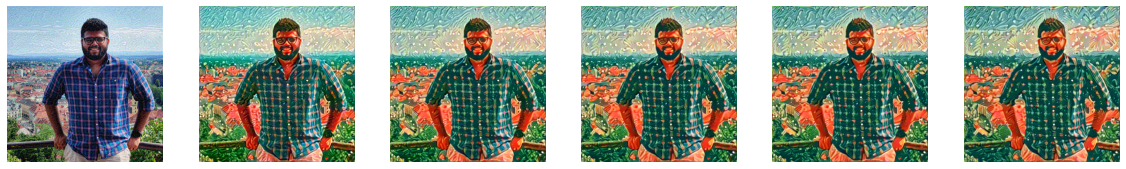

In [ ]:
plt.figure(figsize=(20,20))
for i in range(len(results)):
  plt.subplot(6, 6, i+1)
  plt.imshow(results[i])
  plt.axis('off')
plt.show()

(-0.5, 499.5, 499.5, -0.5)

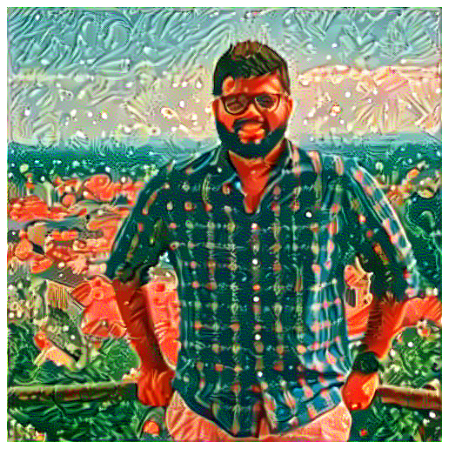

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(results[2])
plt.axis('off')

(-0.5, 486.5, 486.5, -0.5)

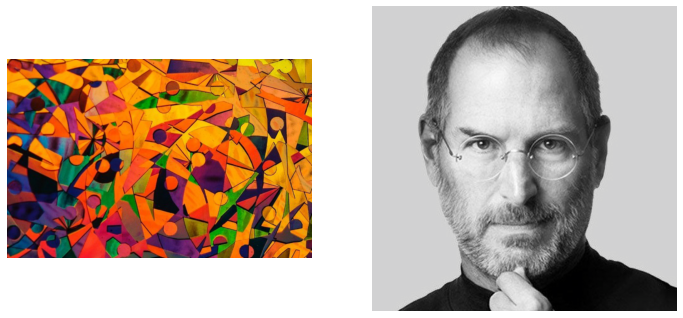

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2, 1)
plt.imshow(undo_tfm_img(sty.clone()))
plt.axis('off')
plt.subplot(1,2, 2)
plt.imshow(undo_tfm_img(img.clone()))
plt.axis('off')